In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset

class SurgicalSegmentationDatasetAll(Dataset):
    def __init__(self, frames_root, masks_root, skip_every=5):
        self.samples = []
        self.skip_every = skip_every

        for video_id in sorted(os.listdir(frames_root)):
            frames_dir = os.path.join(frames_root, video_id)
            masks_dir = os.path.join(masks_root, video_id, "segmentation")

            if not os.path.exists(masks_dir):
                continue

            mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(".png")])

            for i, mask_file in enumerate(mask_files):
                if i % self.skip_every != 0:
                    continue
                base = mask_file.replace(".png", "")
                frame_path = os.path.join(frames_dir, f"{base}.jpg")
                mask_path = os.path.join(masks_dir, mask_file)

                if not os.path.exists(frame_path):
                    continue

                # ✅ Check if mask is not empty
                mask_check = cv2.imread(mask_path)
                if mask_check is None:
                    continue
                if not np.any(mask_check != 0):
                    continue  # skip all-black masks

                self.samples.append((frame_path, mask_path))

        print(f"✅ Loaded {len(self.samples)} image-mask pairs (every {self.skip_every}th frame, non-empty masks only)")


    def __getitem__(self, idx):
        frame_path, mask_path = self.samples[idx]
        resize_to = (384, 384)

        # Load and preprocess image
        image = cv2.imread(frame_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, resize_to)
        image = transforms.ToTensor()(image)

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # just one channel
        mask = cv2.resize(mask, resize_to, interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask).long()

        return image, mask

    def __len__(self):
        return len(self.samples)


In [3]:
# Define the UNet Model
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.down1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.middle = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.upconv3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.upconv2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.upconv1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)


    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        m = self.middle(self.pool3(d3))
        u3 = self.upconv3(torch.cat([self.up3(m), d3], dim=1))
        u2 = self.upconv2(torch.cat([self.up2(u3), d2], dim=1))
        u1 = self.upconv1(torch.cat([self.up1(u2), d1], dim=1))
        return self.final(u1)


In [4]:
dataset = SurgicalSegmentationDatasetAll(
    frames_root="/content/drive/MyDrive/Image_Vision/extracted_frames",
    masks_root="/content/drive/MyDrive/Image_Vision/unzipped_videos",
    skip_every=5  # or 10 to reduce size
)

img, msk = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", msk.shape)
print("Unique labels in mask:", torch.unique(msk))

✅ Loaded 2583 image-mask pairs (every 5th frame, non-empty masks only)
Image shape: torch.Size([3, 384, 384])
Mask shape: torch.Size([384, 384])
Unique labels in mask: tensor([0, 1, 2, 3, 8])


In [5]:
#Split & create DataLoaders:

from torch.utils.data import random_split, DataLoader

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4)

In [6]:
import gc
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

model = UNet(n_classes=10).to(device)
ce_loss = nn.CrossEntropyLoss()

def dice_loss(pred, target, smooth=1.):
    pred = torch.softmax(pred, dim=1)  # (B, 10, H, W)
    target_onehot = torch.nn.functional.one_hot(target, num_classes=10).permute(0, 3, 1, 2).float()
    intersection = (pred * target_onehot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_onehot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


optimizer = optim.Adam(model.parameters(), lr=1e-4)

def evaluate(model, loader):
    model.eval()
    total_dice = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            total_dice += 1 - dice_loss(outputs, masks)
    return total_dice / len(loader)

n_epochs = 10
best_dice = 0.0

for epoch in range(n_epochs):
    gc.collect()
    torch.cuda.empty_cache()

    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_dice = evaluate(model, val_loader)

    print(f"📊 Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Val Dice={avg_val_dice:.4f}")

    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        save_path = "/content/drive/MyDrive/Image_Vision/models/best_unet.pth"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved! Dice={best_dice:.4f}")


✅ Using device: cuda


Epoch 1/10: 100%|██████████| 581/581 [1:00:24<00:00,  6.24s/it]


📊 Epoch 1: Train Loss=1.5717 | Val Dice=0.1836
✅ Best model saved! Dice=0.1836


Epoch 2/10: 100%|██████████| 581/581 [02:04<00:00,  4.65it/s]


📊 Epoch 2: Train Loss=1.1821 | Val Dice=0.3880
✅ Best model saved! Dice=0.3880


Epoch 3/10: 100%|██████████| 581/581 [02:04<00:00,  4.66it/s]


📊 Epoch 3: Train Loss=1.0663 | Val Dice=0.4239
✅ Best model saved! Dice=0.4239


Epoch 4/10: 100%|██████████| 581/581 [02:04<00:00,  4.65it/s]


📊 Epoch 4: Train Loss=1.0025 | Val Dice=0.4200


Epoch 5/10: 100%|██████████| 581/581 [02:03<00:00,  4.69it/s]


📊 Epoch 5: Train Loss=0.9492 | Val Dice=0.4621
✅ Best model saved! Dice=0.4621


Epoch 6/10: 100%|██████████| 581/581 [02:04<00:00,  4.67it/s]


📊 Epoch 6: Train Loss=0.9027 | Val Dice=0.4804
✅ Best model saved! Dice=0.4804


Epoch 7/10: 100%|██████████| 581/581 [02:04<00:00,  4.66it/s]


📊 Epoch 7: Train Loss=0.8745 | Val Dice=0.4972
✅ Best model saved! Dice=0.4972


Epoch 8/10: 100%|██████████| 581/581 [02:04<00:00,  4.67it/s]


📊 Epoch 8: Train Loss=0.8430 | Val Dice=0.5060
✅ Best model saved! Dice=0.5060


Epoch 9/10: 100%|██████████| 581/581 [02:04<00:00,  4.66it/s]


📊 Epoch 9: Train Loss=0.8311 | Val Dice=0.4891


Epoch 10/10: 100%|██████████| 581/581 [02:03<00:00,  4.69it/s]


📊 Epoch 10: Train Loss=0.8002 | Val Dice=0.5236
✅ Best model saved! Dice=0.5236


In [8]:
def dice_per_class(preds, targets, num_classes=10):
    dices = []
    preds = torch.argmax(preds, dim=1)

    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()

        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        dices.append(dice.item())
    return dices

model.eval()
all_dices = np.zeros(10)
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)

        dices = dice_per_class(outputs, masks, num_classes=10)
        all_dices += np.array(dices)

avg_dice_per_class = all_dices / len(val_loader)
for i, d in enumerate(avg_dice_per_class):
    print(f"Class {i} Dice: {d:.4f}")


Class 0 Dice: 0.9669
Class 1 Dice: 0.5567
Class 2 Dice: 0.6627
Class 3 Dice: 0.8893
Class 4 Dice: 0.4447
Class 5 Dice: 0.1490
Class 6 Dice: 0.7077
Class 7 Dice: 0.9077
Class 8 Dice: 0.0154
Class 9 Dice: 0.7474


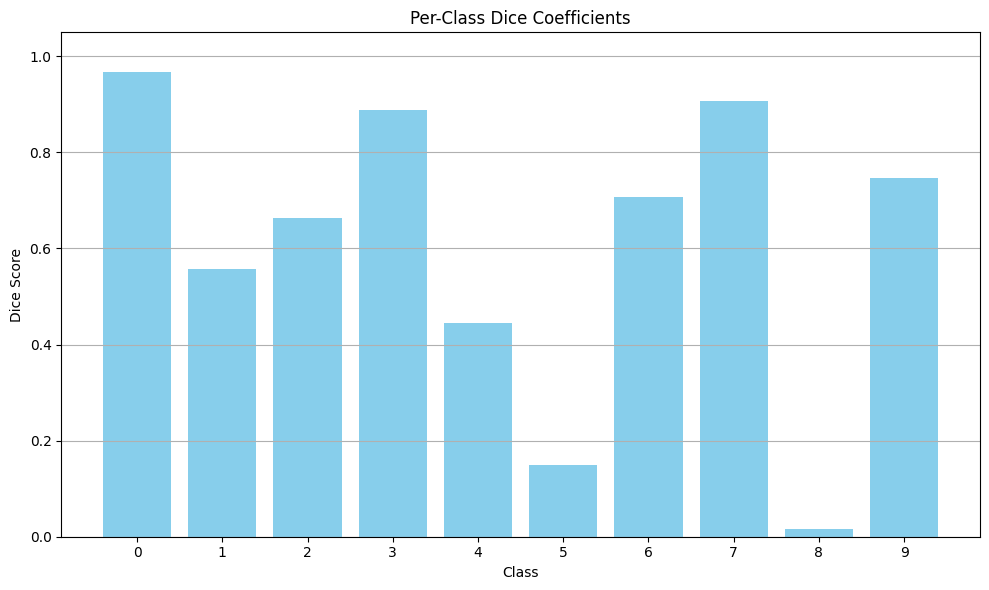

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Replace with your values or calculate dynamically
dice_scores = {
    0: 0.9669,
    1: 0.5567,
    2: 0.6627,
    3: 0.8893,
    4: 0.4447,
    5: 0.1490,
    6: 0.7077,
    7: 0.9077,
    8: 0.0154,
    9: 0.7474,
}

# Plot
classes = list(dice_scores.keys())
scores = [dice_scores[c] for c in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, scores, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Dice Score')
plt.title('Per-Class Dice Coefficients')
plt.ylim(0, 1.05)
plt.xticks(classes)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("dice_scores_plot.png")
plt.show()
